<a href="https://colab.research.google.com/github/jlee1998/Kernel-Flows-for-Irregular-Time-Series/blob/main/Henon_New.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import tqdm

In [ ]:
import numpy as np

def Henon(T, dt, N_sims,a=1.4,b=0.3,x0=0,y0=0):
    N_t  = int(T//dt)
    sims = np.zeros((N_sims, N_t, 2))
    sims[:,0]= np.array([x0,y0]).T
    for i in range(1,N_t):
        sims[:, i] = np.array([1-a*sims[:,i-1,0]**2+sims[:,i-1,1],b*sims[:,i-1,0]]).T
    return sims.astype(np.float32)


In [ ]:
def prepare_data(data_x,delay, normalize):
    lenX=data_x.shape[1]
    num_modes = data_x.shape[0]
    
    X=np.zeros((1+lenX-2*delay,delay*num_modes))
    Y=np.zeros((1+lenX-2*delay,delay*num_modes))
    for mode in range(num_modes):
        for i in range(1+lenX-2*delay):
            X[i,(mode*delay):(mode*delay+delay)]=data_x[mode,i:(i+delay)]
            Y[i,(mode*delay):(mode*delay+delay)]=data_x[mode,(i+delay):(i+2*delay)]
    
            
    # Normalize
    X=X/normalize
    Y=Y/normalize
    return X, Y

def prepare_data_fast(data_x, delay, normalize, irregular_delays = None):
    data = data_x.T / normalize
    Y = data[delay:]
    
    #irregular_delays_norm = (irregular_delays-irregular_delays.mean()) / irregular_delays.std()
    if irregular_delays is not None:
        data = np.concatenate((data,irregular_delays[...,None]),-1)
    
    X = np.zeros((data.shape[0]-delay,delay*data.shape[1]))

    for i in range(X.shape[0]):
        X[i] = data[i:(i+delay)].reshape(-1)
    
    return X, Y

def prepare_irregular_data(data_x,delay, normalize, delays):

    assert delay==1 # This is currrently validated for delay 1 only. Extra stuff required to generalize.

    lenX=data_x.shape[1]
    num_modes = data_x.shape[0]
    
    X=np.zeros((1+lenX-2*delay,delay*num_modes))
    Y=np.zeros((1+lenX-2*delay,delay*num_modes))
    for mode in range(num_modes):
        for i in range(1+lenX-2*delay):
            X[i,(mode*delay):(mode*delay+delay)]=data_x[mode,i:(i+delay)]
            Y[i,(mode*delay):(mode*delay+delay)]=data_x[mode,(i+delay):(i+2*delay)]
    
            
    # Normalize
    X=X/normalize
    Y=Y/normalize

    X = np.concatenate((X,delays[...,None][:-1]),-1)

    return X, Y

In [ ]:
import torch
import numpy as np
#%% Kernel operations

# Returns the norm of the pairwise difference
def norm_matrix(matrix_1, matrix_2):
    norm_square_1 = torch.sum(torch.square(matrix_1), axis = 1)
    norm_square_1 = torch.reshape(norm_square_1, (-1,1))
    
    norm_square_2 = torch.sum(torch.square(matrix_2), axis = 1)
    norm_square_2 = torch.reshape(norm_square_2, (-1,1))
    
    d1=matrix_1.shape
    d2=matrix_2.shape
#   print(d1)
#   print(d2)
    if d1[1]!=d2[1]:
        matrix_1=torch.transpose(matrix_1)
    
    inner_matrix = torch.matmul(matrix_1, torch.transpose(matrix_2,0,1))
    
    norm_diff = -2 * inner_matrix + norm_square_1 + torch.transpose(norm_square_2,0,1)
#    print(norm_diff.shape)
    
    return norm_diff



# Returns the pairwise inner product
def inner_matrix(matrix_1, matrix_2):
    d1=matrix_1.shape
    d2=matrix_2.shape
    # print(d1)
    # print(d2)
    if d1[1]!=d2[1]:
        matrix_1=torch.transpose(matrix_1,0,1)
    return torch.matmul(matrix_1, torch.transpose(matrix_2,0,1))

def kernel_anl3(matrix_1, matrix_2, parameters):
    i=0
    
    matrix = norm_matrix(matrix_1, matrix_2)
    sigma = parameters[i+0]
    K =  torch.exp(-matrix/ (2* sigma**2))
    K=K*(parameters[i+1])**2
    i=i+2
    
    
    c = (parameters[i])**2
    imatrix = inner_matrix(matrix_1, matrix_2)
    K = K+ (parameters[i+1])**2 *(imatrix+c) ** 2
    i=i+2
    
    beta = parameters[i]
    gamma = (parameters[i+1])**2
    K=K+ (parameters[i+2])**2 *(beta**2 + gamma*matrix)**(-1/2)
    i=i+3
    
    alpha = parameters[i]
    beta = parameters[i+1]
    K=K+ (parameters[i+2])**2 *(beta**2 + matrix)**(-alpha)
    i=i+3
    
    sigma = parameters[i]
    K=K+ (parameters[i+1])**2 * 1/(1 + matrix/sigma**2)
    i=i+2
    
    alpha_0 = parameters[i]
    sigma_0 = parameters[i+1]
    alpha_1 = parameters[i+2]
    sigma_1 = parameters[i+3]
    K =  K+ (parameters[i+4])**2 *alpha_0*torch.maximum(torch.zeros(1,device = parameters.device), 1-matrix/(sigma_0))+ alpha_1 * torch.exp(-matrix/ (2* sigma_1**2))
    i=i+5
    
    p = parameters[i]
    l = parameters[i+1]
    sigma = parameters[i+2]
    K =K+ (parameters[i+3])**2 * torch.exp(-torch.sin(matrix*np.pi/p)**2/l**2)*torch.exp(-matrix/sigma**2)
    i=i+4
    
    p = parameters[i]
    l = parameters[i+1]
    K = K+ (parameters[i+2])**2 *torch.exp(-torch.sin(matrix*np.pi/p)/l**2)
    i=i+3
    
    return K

In [ ]:
import numpy as np
import torch
import math
import tqdm

def sample_selection(N, size):
    indices = np.arange(N)
    sample_indices = np.sort(np.random.choice(indices, size, replace= False))
    #sample_indices = indices[:size]
    return sample_indices

# The pi or selection matrix
def pi_matrix(sample_indices, dimension):
    pi = torch.zeros(dimension).double()
    
    for i in range(dimension[0]):
        pi[i][sample_indices[i]] = 1
    
    return pi

def batch_creation(N, batch_size, sample_proportion = 0.5):
    if batch_size == False:
        batch_indices = np.arange(N)
    elif 0 < batch_size <= 1:
        batch_size = int(N * batch_size)
        batch_indices = sample_selection(N, batch_size)
    else:
        batch_indices = sample_selection(N, batch_size)
        
    # Sample from the mini-batch
    sample_size = math.ceil(len(batch_indices)*sample_proportion)
    sample_indices = sample_selection(len(batch_indices), sample_size)
    
    return sample_indices, batch_indices

class KernelFlows(torch.nn.Module):
    
    def __init__(self, kernel_keyword, nparameters, regu_lambda, dim, metric = "rho_ratio", batch_size = 100):
        super().__init__()
        self.kernel_keyword = kernel_keyword
        
        self.regu_lambda = regu_lambda

        self.kernel_params = torch.nn.Parameter(torch.ones(nparameters),requires_grad = True)
        self.kernel = kernel_anl3

        self.dim = dim

        self.batch_size = batch_size

        if metric == "rho_ratio":
            self.rho_fun = self.rho_ratio
        elif metric == "rho_general":
            self.rho_fun = self.rho_general
        else:
            raise("Metric not supported")
        self.metric = metric

    def get_parameters(self):
        return self.kernel_params
    
    def set_train(self, train):
        self.train = train

    def set_training_data(self,X,Y):
        self.X_train = X
        self.Y_train = Y


    def rho_ratio(self, matrix_data, Y_data, sample_indices,  regu_lambda = 0.000001):
        
        kernel_matrix = self.kernel(matrix_data, matrix_data, self.kernel_params)
        pi = pi_matrix(sample_indices, (sample_indices.shape[0], matrix_data.shape[0])).to(matrix_data.device) 
        
        sample_matrix = torch.matmul(pi, torch.matmul(kernel_matrix, torch.transpose(pi,0,1)))
        
        Y_sample = Y_data[sample_indices]
        
        inverse_data = torch.linalg.inv(kernel_matrix + regu_lambda * torch.eye(kernel_matrix.shape[0], device = matrix_data.device))
        inverse_sample = torch.linalg.inv(sample_matrix + regu_lambda * torch.eye(sample_matrix.shape[0], device = matrix_data.device))

        top = torch.tensordot(Y_sample, torch.matmul(inverse_sample, Y_sample))
        
        bottom = torch.tensordot(Y_data, torch.matmul(inverse_data, Y_data))
        
        return 1 - top/bottom 
    
    def rho_general(self, matrix_data, Y_data,  regu_lambda = 0.000001, **kwargs):
        
        kernel_matrix = self.kernel(matrix_data, matrix_data, self.kernel_params)

        kernel_matrix = kernel_matrix / torch.trace(kernel_matrix)
        
        inverse_matrix = torch.linalg.inv(kernel_matrix + regu_lambda * torch.eye(kernel_matrix.shape[0]))
        
        rho = torch.tensordot(Y_data, torch.matmul(inverse_matrix, Y_data))
        
        return rho

    def forward(self, adaptive_size = False, proportion = 0.5):            
        
        if adaptive_size == False or adaptive_size == "Dynamic":
            sample_size = proportion
        elif adaptive_size == "Linear":
            sample_size_array = sample_size_linear(iterations, adaptive_range) 
        else:
            print("Sample size not recognized")
            
                
        # Create a batch and a sample
        sample_indices, batch_indices = batch_creation(self.X_train.shape[0], batch_size= self.batch_size, sample_proportion = sample_size)
        X_data = self.X_train[batch_indices]
        Y_data = self.Y_train[batch_indices]
        
        #optimizer and backward

        rho = self.rho_fun( X_data, Y_data, 
                                       sample_indices = sample_indices, regu_lambda = self.regu_lambda)
           
        return rho

    def compute_kernel_and_inverse(self,regu_lambda = 0.0000001):
        X_data = self.X_train
        self.kernel_matrix = self.kernel(X_data,X_data, self.kernel_params)
        self.kernel_matrix += regu_lambda * torch.eye(self.kernel_matrix.shape[0], device = X_data.device)
        
        self.inverse_kernel = torch.linalg.inv(self.kernel_matrix)
        self.A_matrix = torch.matmul(self.inverse_kernel,self.Y_train)

        return self.kernel_matrix

    def predict(self,x_test):
        kernel_pred = self.kernel(x_test,self.X_train,self.kernel_params)
        prediction = torch.matmul(kernel_pred,self.A_matrix)
        return prediction

    def predict_ahead(self,x_test, horizon, delay, delta_t_mode = False, device = None):
        """
        Perform n=horizon steps ahead prediction.
        If delta_t_mode is True, x_test is expected to have the the following structure (X(t-1),delta_t-1,X(t),delta_t))
        
        out_dim is the dimension of the y vector (and of the observations in x as well)
        delay : delay used in the x
        """
        assert horizon >0 # minimum horizon is 1
        assert delay >0 

        Y_p = torch.zeros((x_test.shape[0],self.dim))
        X_test_ = torch.Tensor(x_test).double().to(device)

        if delta_t_mode:
            indices_delays = [((self.dim+1)*i,(self.dim+1)*i+1) for i in range(delay)] # We should not touch the delta t
        else:
            indices_delays = [(self.dim*i,self.dim*i+1) for i in range(delay)]
        
        # Make sure there is no contamination (deleting the previous values)
        for dim in range(horizon):
            n_delays = min(dim,delay)
            for n in range(1,n_delays+1):
                X_test_[dim::horizon][:,indices_delays[-n]] = 0

        # Predicting and propagating predictions to the next step.
        for dim in range(horizon):
    
            Y_p[dim::horizon] = self.predict(X_test_[dim::horizon])
            
            for dim_plus in range(dim+1,min(horizon,delay+dim+1)):
                
                l_x = X_test_[dim_plus::horizon].shape[0]
                idx = dim_plus-dim

                X_test_[dim_plus::horizon][:,indices_delays[-1*idx][0]:1+indices_delays[-1*idx][1]] = Y_p[dim::horizon][:l_x] # should be -1-2:-1 for irregular

        return Y_p

def train_kernel(X_train, Y_train, model,  lr = 0.1, verbose= True,epochs=1000):
    """
    dim is the dimension of a single observation
    """ 
    #model = KernelFlows(kernel_name,nparameters= nparameters, regu_lambda=regu_lambda, dim = dim)
    optimizer = torch.optim.SGD(model.parameters(), lr = lr)

    model.set_training_data(torch.Tensor(X_train).double(),torch.Tensor(Y_train).double())
    rho_list=[]

    for i in tqdm.tqdm(range(epochs)):
        optimizer.zero_grad()
        rho = model.forward()
        rho_list.append(rho.detach().numpy())
        if rho>=0 and rho<=1 and model.metric=="rho_ratio":
            rho.backward()
            optimizer.step()
            if verbose:
                print(rho)
            
    return model, rho_list

## Regular Henon

### 1 step









In [ ]:
# generate dataset
Data = Henon(T=200, dt=0.1,N_sims=1,a=1.4,b=0.3)[0]
#train test split
observed_data= Data
train_data = Data[:600,:].T
test_data = Data[600:,:].T
#times
Times = np.linspace(1,2000-1,2000-1)

# Some constants
nparameters=24
delay = 4
regu_lambda = 0.00001

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = prepare_data_fast(train_data,delay,normalize)
X_test, Y_test = prepare_data_fast(test_data,delay,normalize)

model= KernelFlows("anl3", nparameters = nparameters, regu_lambda = regu_lambda, dim = 2, metric = "rho_ratio", batch_size = 100)
model= train_kernel(X_train, Y_train, model, lr = 0.1)

  1%|          | 10/1000 [00:00<00:46, 21.48it/s]

tensor(0.8910, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1369, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1670, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.1366, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.3634, dtype=torch.float64, grad_fn=<RsubBackward1>)


  2%|▏         | 20/1000 [00:00<00:30, 31.89it/s]

tensor(0.3954, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.2128, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0408, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0844, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0887, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0531, dtype=torch.float64, grad_fn=<RsubBackward1>)


  3%|▎         | 30/1000 [00:01<00:25, 38.04it/s]

tensor(0.0504, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0488, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0569, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0716, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0408, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0414, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0484, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0752, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0517, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0556, dtype=torch.float64, grad_fn=<RsubBackward1>)


  4%|▎         | 35/1000 [00:01<00:27, 35.32it/s]

tensor(0.0670, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0323, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0511, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0642, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0485, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0597, dtype=torch.float64, grad_fn=<RsubBackward1>)


  4%|▍         | 43/1000 [00:01<00:27, 34.45it/s]

tensor(0.0386, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0651, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0503, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0574, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0307, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0374, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0326, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0379, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0469, dtype=torch.float64, grad_fn=<RsubBackward1>)


  5%|▌         | 52/1000 [00:01<00:26, 36.05it/s]

tensor(0.0369, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0398, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0441, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0350, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0163, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0320, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0357, dtype=torch.float64, grad_fn=<RsubBackward1>)


  6%|▌         | 61/1000 [00:01<00:25, 37.21it/s]

tensor(0.0496, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0230, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0281, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0279, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0457, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0328, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0369, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0373, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0231, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0377, dtype=torch.float64, grad_fn=<RsubBackward1>)


  7%|▋         | 67/1000 [00:02<00:21, 43.12it/s]

tensor(0.0206, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0223, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0322, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0407, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0222, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0138, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0213, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0283, dtype=torch.float64, grad_fn=<RsubBackward1>)


  8%|▊         | 77/1000 [00:02<00:23, 39.20it/s]

tensor(0.0182, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0442, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0132, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0290, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0336, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0263, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0267, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0179, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0254, dtype=torch.float64, grad_fn=<RsubBackward1>)


  9%|▊         | 87/1000 [00:02<00:24, 37.74it/s]

tensor(0.0134, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0241, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0159, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0165, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0229, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0202, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0221, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0136, dtype=torch.float64, grad_fn=<RsubBackward1>)


 10%|▉         | 99/1000 [00:02<00:19, 46.54it/s]

tensor(0.0208, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0121, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0208, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0289, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0159, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0212, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0243, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0304, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0226, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0129, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0293, dtype=torch.float64, grad_fn=<RsubBackward1>)


 11%|█         | 110/1000 [00:02<00:17, 49.85it/s]

tensor(0.0219, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0167, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0137, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0202, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0120, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0192, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0288, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0171, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0221, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0097, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0137, dtype=torch.float64, grad_fn=<RsubBackward1>)


 12%|█▏        | 116/1000 [00:03<00:18, 46.86it/s]

tensor(0.0165, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0187, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0141, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0083, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0157, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0132, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0137, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0179, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0136, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0136, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0159, dtype=torch.float64, grad_fn=<RsubBackward1>)


 13%|█▎        | 128/1000 [00:03<00:17, 50.80it/s]

tensor(0.0109, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0156, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0225, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0220, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0112, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0302, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0076, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0131, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0124, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0117, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0095, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0112, dtype=torch.float64, grad_fn=<RsubBackward1>)


 14%|█▍        | 140/1000 [00:03<00:17, 48.34it/s]

tensor(0.0085, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0094, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0178, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0311, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0190, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0126, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0079, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0053, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0078, dtype=torch.float64, grad_fn=<RsubBackward1>)

 15%|█▌        | 152/1000 [00:03<00:16, 50.93it/s]


tensor(0.0148, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0218, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0108, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0116, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0239, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0108, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0131, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0097, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0105, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0147, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0115, dtype=torch.float64, grad_fn=<RsubBackward1>)


 16%|█▋        | 163/1000 [00:04<00:17, 48.46it/s]

tensor(0.0138, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0098, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0092, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0198, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0096, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0221, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0099, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0084, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0135, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0128, dtype=torch.float64, grad_fn=<RsubBackward1>)


 17%|█▋        | 173/1000 [00:04<00:18, 45.45it/s]

tensor(0.0145, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0270, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0236, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0080, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0121, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0142, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0086, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0131, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0107, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0083, dtype=torch.float64, grad_fn=<RsubBackward1>)


 18%|█▊        | 178/1000 [00:04<00:17, 46.56it/s]

tensor(0.0098, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0092, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0187, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0078, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0050, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0110, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0082, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0058, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0055, dtype=torch.float64, grad_fn=<RsubBackward1>)


 19%|█▉        | 188/1000 [00:04<00:22, 35.85it/s]

tensor(0.0104, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0244, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0088, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0161, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0082, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0218, dtype=torch.float64, grad_fn=<RsubBackward1>)


 20%|█▉        | 197/1000 [00:04<00:21, 38.22it/s]

tensor(0.0123, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0122, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0252, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0137, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0083, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0112, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0160, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0172, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0049, dtype=torch.float64, grad_fn=<RsubBackward1>)


 21%|██        | 208/1000 [00:05<00:17, 44.78it/s]

tensor(0.0105, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0226, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0092, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0141, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0091, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0098, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0063, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0082, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0089, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0100, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0083, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0070, dtype=torch.float64, grad_fn=<RsubBackward1>)


 22%|██▏       | 219/1000 [00:05<00:16, 48.62it/s]

tensor(0.0138, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0198, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0112, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0073, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0061, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0074, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0084, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0104, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0050, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0070, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0093, dtype=torch.float64, grad_fn=<RsubBackward1>)


 23%|██▎       | 229/1000 [00:05<00:16, 45.39it/s]

tensor(0.0095, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0092, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0150, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0064, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0049, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0076, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0114, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0064, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0056, dtype=torch.float64, grad_fn=<RsubBackward1>)


 23%|██▎       | 234/1000 [00:05<00:17, 42.66it/s]

tensor(0.0087, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0142, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0040, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0084, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0042, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0151, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0114, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0087, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0115, dtype=torch.float64, grad_fn=<RsubBackward1>)


 25%|██▍       | 246/1000 [00:06<00:15, 47.38it/s]

tensor(0.0063, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0143, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0071, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0063, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0045, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0070, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0085, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0061, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0106, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0088, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0073, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0053, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0069, dtype=torch.float64, grad_fn=<RsubBackward1>)


 26%|██▌       | 259/1000 [00:06<00:13, 54.05it/s]

tensor(0.0053, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0054, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0093, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0166, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0093, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0074, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0038, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0089, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0203, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0062, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0044, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0074, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0130, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0042, dtype=torch.float64, grad_fn=<RsubBackward1>)


 27%|██▋       | 272/1000 [00:06<00:12, 56.99it/s]

tensor(0.0093, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0064, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0095, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0103, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0032, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0078, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0045, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0070, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0083, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0065, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0156, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0074, dtype=torch.float64, grad_fn=<RsubBackward1>)


 28%|██▊       | 284/1000 [00:06<00:12, 56.09it/s]

tensor(0.0053, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0101, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0038, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0075, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0068, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0039, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0094, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0061, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0046, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0138, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0122, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0067, dtype=torch.float64, grad_fn=<RsubBackward1>)


 30%|██▉       | 296/1000 [00:06<00:12, 54.16it/s]

tensor(0.0087, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0061, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0028, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0057, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0024, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0110, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0082, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0038, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0103, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0104, dtype=torch.float64, grad_fn=<RsubBackward1>)


 30%|███       | 302/1000 [00:07<00:13, 49.87it/s]

tensor(0.0052, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0040, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0054, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0105, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0027, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0047, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0073, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0054, dtype=torch.float64, grad_fn=<RsubBackward1>)


 32%|███▏      | 315/1000 [00:07<00:15, 45.04it/s]

tensor(0.0095, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0072, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0091, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0077, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0057, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0067, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0114, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0115, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0067, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0039, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0029, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0114, dtype=torch.float64, grad_fn=<RsubBackward1>)


 32%|███▎      | 325/1000 [00:07<00:17, 38.52it/s]

tensor(0.0088, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0060, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0039, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0116, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0080, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0042, dtype=torch.float64, grad_fn=<RsubBackward1>)


 33%|███▎      | 330/1000 [00:07<00:19, 34.21it/s]

tensor(0.0047, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0048, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0057, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0037, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0087, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0076, dtype=torch.float64, grad_fn=<RsubBackward1>)


 34%|███▍      | 340/1000 [00:08<00:16, 39.47it/s]

tensor(0.0081, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0051, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0058, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0087, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0101, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0029, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0053, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0037, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0054, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0086, dtype=torch.float64, grad_fn=<RsubBackward1>)


 34%|███▍      | 345/1000 [00:08<00:17, 38.34it/s]

tensor(0.0076, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0048, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0089, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0054, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0046, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0059, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0072, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0030, dtype=torch.float64, grad_fn=<RsubBackward1>)


 35%|███▌      | 354/1000 [00:08<00:17, 37.59it/s]

tensor(0.0039, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0070, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0051, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0062, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0037, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0034, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0020, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0083, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0056, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0049, dtype=torch.float64, grad_fn=<RsubBackward1>)


 36%|███▋      | 365/1000 [00:08<00:14, 43.23it/s]

tensor(0.0020, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0033, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0024, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0026, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0026, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0057, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0080, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0025, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0025, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0033, dtype=torch.float64, grad_fn=<RsubBackward1>)


 38%|███▊      | 375/1000 [00:08<00:16, 38.80it/s]

tensor(0.0052, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0094, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0136, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0043, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0071, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0137, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0068, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0026, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0029, dtype=torch.float64, grad_fn=<RsubBackward1>)


 39%|███▊      | 386/1000 [00:09<00:14, 43.13it/s]

tensor(0.0031, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0050, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0064, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0093, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0026, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0067, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0032, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0070, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0069, dtype=torch.float64, grad_fn=<RsubBackward1>)


 40%|███▉      | 399/1000 [00:09<00:11, 50.12it/s]

tensor(0.0036, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0032, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0081, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0082, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0086, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0033, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0060, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0087, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0019, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0098, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0033, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0060, dtype=torch.float64, grad_fn=<RsubBackward1>)


 41%|████      | 411/1000 [00:09<00:11, 51.92it/s]

tensor(0.0070, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0042, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0034, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0044, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0020, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0064, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0033, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0051, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0041, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0036, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0036, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0054, dtype=torch.float64, grad_fn=<RsubBackward1>)


 43%|████▎     | 427/1000 [00:09<00:08, 65.61it/s]

tensor(0.0033, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0083, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0041, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0078, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0034, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0069, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0027, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0029, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0024, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0112, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0056, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0022, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0046, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0023, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0048, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0073, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0048, dtype=tor

 44%|████▍     | 442/1000 [00:10<00:08, 68.33it/s]

tensor(0.0028, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0037, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0074, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0028, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0128, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0047, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0021, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0027, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0020, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0015, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0053, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0037, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0061, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0021, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0016, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0023, dtype=torch.float64, grad_fn=<RsubBackward1>)


 46%|████▌     | 457/1000 [00:10<00:07, 68.69it/s]

tensor(0.0036, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0020, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0057, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0058, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0032, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0035, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0047, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0033, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0050, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0053, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0023, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0035, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0055, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0081, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0080, dtype=torch.float64, grad_fn=<RsubBackward1>)


 47%|████▋     | 472/1000 [00:10<00:07, 70.74it/s]

tensor(0.0066, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0026, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0080, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0028, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0019, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0062, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0036, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0112, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0029, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0035, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0031, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0056, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0059, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0029, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0030, dtype=torch.float64, grad_fn=<RsubBackward1>)


 49%|████▉     | 488/1000 [00:10<00:06, 73.58it/s]

tensor(0.0076, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0037, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0039, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0040, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0047, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0045, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0020, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0027, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0052, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0049, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0017, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0054, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0018, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0055, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0031, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0050, dtype=torch.float64, grad_fn=<RsubBackward1>)


 50%|█████     | 504/1000 [00:10<00:06, 72.58it/s]

tensor(0.0032, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0038, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0011, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0043, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0032, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0038, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0047, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0032, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0012, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0022, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0022, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0089, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0079, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0043, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0035, dtype=torch.float64, grad_fn=<RsubBackward1>)


 52%|█████▏    | 520/1000 [00:11<00:06, 75.36it/s]

tensor(0.0032, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0019, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0044, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0088, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0091, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0041, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0096, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0046, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0023, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0046, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0021, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0069, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0052, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0033, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0031, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0027, dtype=torch.float64, grad_fn=<RsubBackward1>)


 54%|█████▎    | 536/1000 [00:11<00:06, 76.16it/s]

tensor(0.0074, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0043, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0019, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0022, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0025, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0027, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0069, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0046, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0045, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0045, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0023, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0017, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0044, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0036, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0021, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0038, dtype=torch.float64, grad_fn=<RsubBackward1>)


 55%|█████▌    | 552/1000 [00:11<00:06, 73.93it/s]

tensor(0.0024, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0032, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0029, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0018, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0043, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0025, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0028, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0090, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0064, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0039, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0028, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0055, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0014, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0066, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0020, dtype=torch.float64, grad_fn=<RsubBackward1>)


 57%|█████▋    | 568/1000 [00:11<00:05, 74.91it/s]

tensor(0.0031, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0057, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0085, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0023, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0038, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0040, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0014, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0019, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0063, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0040, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0028, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0029, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0039, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0026, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0021, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0031, dtype=torch.float64, grad_fn=<RsubBackward1>)


 58%|█████▊    | 576/1000 [00:11<00:05, 72.79it/s]

tensor(0.0017, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0050, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0048, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0024, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0028, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0037, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0030, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0032, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0031, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0069, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0054, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0033, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0040, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0041, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0033, dtype=torch.float64, grad_fn=<RsubBackward1>)


 59%|█████▉    | 592/1000 [00:12<00:05, 71.01it/s]

tensor(0.0032, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0084, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0045, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0040, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0031, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0023, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0016, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0052, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0023, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0022, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0062, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0033, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0020, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0067, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0027, dtype=torch.float64, grad_fn=<RsubBackward1>)

 61%|██████    | 608/1000 [00:12<00:05, 74.53it/s]


tensor(0.0018, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0029, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0080, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0036, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0027, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0043, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0041, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0095, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0008, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0093, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0023, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0041, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0031, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0036, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0015, dtype=torch.float64, grad_fn=<RsubBackward1>)


 62%|██████▏   | 624/1000 [00:12<00:05, 73.14it/s]

tensor(0.0040, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0017, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0026, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0034, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0019, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0034, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0042, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0026, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0029, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0028, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0033, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0022, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0024, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0026, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0042, dtype=torch.float64, grad_fn=<RsubBackward1>)


 64%|██████▍   | 640/1000 [00:12<00:05, 70.96it/s]

tensor(0.0014, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0015, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0023, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0025, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0060, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0058, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0024, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0019, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0029, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0035, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0091, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0017, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0016, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0010, dtype=torch.float64, grad_fn=<RsubBackward1>)


 66%|██████▌   | 655/1000 [00:13<00:05, 67.09it/s]

tensor(0.0056, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0019, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0038, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0015, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0016, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0023, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0032, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0018, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0039, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0028, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0061, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0030, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0053, dtype=torch.float64, grad_fn=<RsubBackward1>)


 67%|██████▋   | 671/1000 [00:13<00:04, 71.93it/s]

tensor(0.0015, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0037, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0021, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0015, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0026, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0029, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0024, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0052, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0043, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0021, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0019, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0033, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0039, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0046, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0018, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0012, dtype=torch.float64, grad_fn=<RsubBackward1>)


 69%|██████▉   | 692/1000 [00:13<00:03, 85.81it/s]

tensor(0.0030, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0027, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0039, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0023, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0010, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0024, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0012, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0031, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0026, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0040, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0055, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0028, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0048, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0018, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0037, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0023, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0011, dtype=tor

 71%|███████   | 712/1000 [00:13<00:03, 90.76it/s]

tensor(0.0019, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0065, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0029, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0064, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0012, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0019, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0021, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0043, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0016, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0017, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0021, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0010, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0018, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0023, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0021, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0036, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0018, dtype=tor

 73%|███████▎  | 732/1000 [00:13<00:02, 93.24it/s]

tensor(0.0040, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0026, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0048, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0016, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0020, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0029, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0038, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0047, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0026, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0039, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0021, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0041, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0015, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0051, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0077, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0065, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0022, dtype=tor

 75%|███████▌  | 753/1000 [00:14<00:02, 94.87it/s]

tensor(0.0012, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0009, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0018, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0038, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0034, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0057, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0017, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0028, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0049, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0038, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0019, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0052, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0007, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0012, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0021, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0032, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0014, dtype=tor

 77%|███████▋  | 773/1000 [00:14<00:02, 94.07it/s]

tensor(0.0041, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0023, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0018, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0040, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0049, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0015, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0024, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0020, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0052, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0048, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0023, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0028, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0046, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0040, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0007, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0056, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0042, dtype=tor

 79%|███████▉  | 793/1000 [00:14<00:02, 94.85it/s]

tensor(0.0021, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0025, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0013, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0012, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0019, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0025, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0017, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0017, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0016, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0021, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0024, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0095, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0011, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0029, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0026, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0052, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0022, dtype=tor

 81%|████████▏ | 814/1000 [00:14<00:01, 97.02it/s]

tensor(0.0018, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0018, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0031, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0021, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0031, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0034, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0080, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0028, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0010, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0010, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0021, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0033, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0030, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0025, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0015, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0016, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0032, dtype=tor

 83%|████████▎ | 834/1000 [00:14<00:01, 95.87it/s]

tensor(0.0014, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0019, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0054, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0023, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0052, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0050, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0017, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0020, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0022, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0013, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0027, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0026, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0010, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0025, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0013, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0034, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0032, dtype=tor

 84%|████████▍ | 844/1000 [00:15<00:01, 92.21it/s]

tensor(0.0011, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0013, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0033, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0014, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0017, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0040, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0015, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0033, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0031, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0029, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0025, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0019, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0027, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0014, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0027, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0015, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0018, dtype=tor

 86%|████████▋ | 865/1000 [00:15<00:01, 96.71it/s]

tensor(0.0028, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0014, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0014, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0010, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0020, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0016, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0016, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0035, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0013, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0008, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0019, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0055, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0014, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0048, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0033, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0011, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0012, dtype=tor

 89%|████████▊ | 887/1000 [00:15<00:01, 98.39it/s]

tensor(0.0030, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0019, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0011, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0021, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0030, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0023, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0013, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0039, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0008, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0025, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0020, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0012, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0012, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0038, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0011, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0026, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0034, dtype=tor

 91%|█████████ | 907/1000 [00:15<00:00, 96.55it/s]

tensor(0.0018, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0016, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0009, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0035, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0030, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0015, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0031, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0015, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0015, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0012, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0013, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0042, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0095, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0020, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0028, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0020, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0025, dtype=tor

 93%|█████████▎| 927/1000 [00:15<00:00, 96.39it/s]

tensor(0.0018, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0025, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0018, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0049, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0016, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0012, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0036, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0020, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0017, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0016, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0009, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0020, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0015, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0010, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0066, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0022, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0012, dtype=tor

 95%|█████████▍| 948/1000 [00:16<00:00, 95.97it/s]

tensor(0.0013, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0014, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0017, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0010, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0010, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0009, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0028, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0027, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0006, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0035, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0025, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0010, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0032, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0013, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0020, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0009, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0056, dtype=tor

 97%|█████████▋| 968/1000 [00:16<00:00, 96.40it/s]

tensor(0.0019, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0014, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0014, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0013, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0017, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0010, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0010, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0050, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0041, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0019, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0018, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0010, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0015, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0035, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0007, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0009, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0014, dtype=tor

 99%|█████████▉| 989/1000 [00:16<00:00, 97.91it/s]

tensor(0.0008, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0045, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0045, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0039, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0022, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0015, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0006, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0012, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0029, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0021, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0008, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0033, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0014, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0015, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0010, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0021, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0048, dtype=tor

100%|██████████| 1000/1000 [00:16<00:00, 60.10it/s]

tensor(0.0014, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0011, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0020, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.0010, dtype=torch.float64, grad_fn=<RsubBackward1>)


In [ ]:
X_train.shape

(596, 8)

In [ ]:
#model.compute_kernel_and_inverse(regu_lambda = regu_lambda)

horizon = 90

Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = False)

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()

print(f"MSE On test : {mse_pred:.4f}")

AttributeError: ignored

In [ ]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda).shape


In [ ]:
model.rho_ratio

In [ ]:
X_test.shape

In [ ]:
np.shape(Y_pred)

In [ ]:
import matplotlib.pyplot as plt
from pylab import rcParams
#rcParams['figure.figsize'] = 10.5, 10.5

plt.scatter(Y_test[:,0],Y_test[:,1], label = "True")
plt.scatter(Y_pred[:,0].detach(),Y_pred[:,1].detach(), label = f"Predicted - horizon {horizon}")
plt.title("Reconstructed Attractor of Henon Map")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [ ]:
plt.plot(Y_test[:,0])
plt.plot(Y_pred[:,0].detach().numpy())


### n steps interval

In [ ]:
n = 2

# generate dataset
Data = Henon(T=200, dt=0.1,N_sims=1,a=1.4,b=0.3)[0]
#train test split
observed_data= Data[0::n]
train_data = observed_data[:600,:].T
test_data = observed_data[600:,:].T
#times
Times = np.linspace(1,2000-1,2000-1)

# Some constants
nparameters=24
delay = 1
regu_lambda = 0.00001

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = prepare_data_fast(train_data,delay,normalize)
X_test, Y_test = prepare_data_fast(test_data,delay,normalize)

model = KernelFlows("anl3", nparameters = nparameters, regu_lambda = regu_lambda, dim = 2, metric = "rho_ratio", batch_size = 100)

model = train_kernel(X_train, Y_train, model, lr = 0.1)

In [ ]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)

horizon = 3

Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = False)

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()

print(f"MSE On test : {mse_pred:.4f}")

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(Y_pred[:,0].detach(),Y_pred[:,1].detach(), label = "Predicted")
plt.scatter(Y_test[:,0],Y_test[:,1], label = "True")
plt.title("Reconstructed Attractor of Henon Map")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# Henon Map with irregular sampling

## Data Generation

In [ ]:
max_delay = 4
N_points = 1000
train_n = 600
burnin = 200
dt = 0.1

delays = np.random.randint(max_delay,size=N_points-1)+1
indices = np.concatenate((np.zeros(1),np.cumsum(delays))).astype(int)
delays = np.concatenate((delays,np.zeros(1))).astype(int)

max_idx = indices[-1]
T = np.ceil(max_idx*dt)
# generate dataset
Data = Henon(T=T+burnin*dt, dt=dt,N_sims=1,a=1.4,b=0.3)[0][burnin:]

observed_data = Data[indices]

train_data = observed_data[:train_n,:].T
test_data = observed_data[train_n:,:].T

delays_train = delays[:train_n]
delays_test = delays[train_n:]

In [ ]:
len(indices[:600])

600

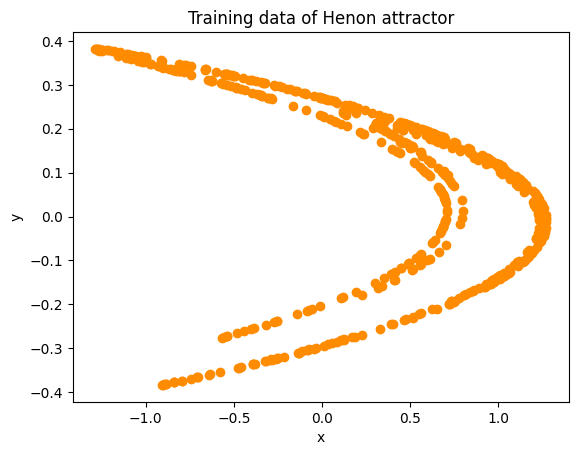

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(train_data[0,:],train_data[1,:],color='darkorange')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training data of Henon attractor')
plt.savefig('henon_train_attractor')

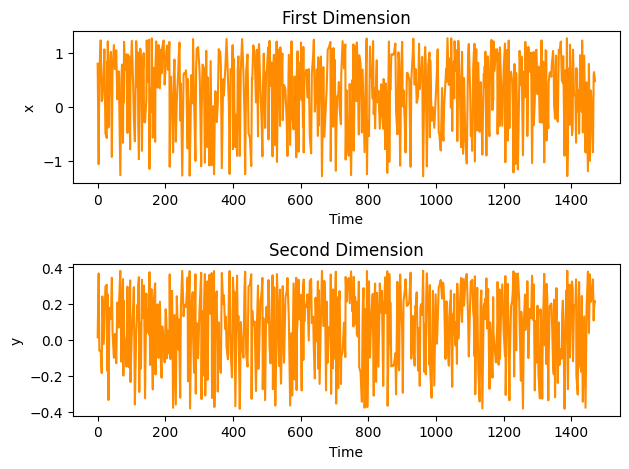

In [ ]:
fig, ax = plt.subplots(2,1)
#fig.set_size_inches(10.5, 5.5)
ax[0].plot(indices[:600],train_data[0,:],color='darkorange')
ax[0].set_ylabel('x')
ax[0].set_xlabel('Time')
ax[0].set_title("First Dimension")


ax[1].plot(indices[:600],train_data[1,:],color='darkorange')
ax[1].set_ylabel('y')
ax[1].set_xlabel('Time')
ax[1].set_title("Second Dimension")
fig.tight_layout()
plt.savefig('henon_train_ts.png',facecolor='white')


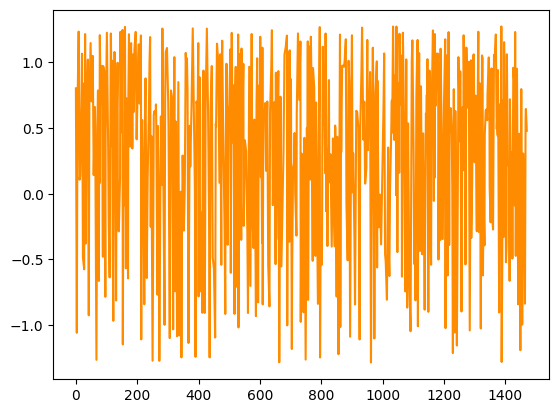

In [ ]:
plt.plot(indices[:600],train_data[0,:],color='darkorange')

# No learning

In [ ]:
# Some constants
nparameters=24
delay = 1
regu_lambda = 0.00001
lr = 0.1

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = prepare_data_fast(train_data,delay,normalize)
X_test, Y_test = prepare_data_fast(test_data,delay,normalize)

model = KernelFlows("anl3", nparameters = nparameters, regu_lambda = regu_lambda, dim = 2, metric = "rho_ratio", batch_size = 100)

model= train_kernel(X_train, Y_train, model, lr = lr,epochs=0)

0it [00:00, ?it/s]


In [ ]:
Y_train.shape

(599, 2)

In [ ]:
sample_indices, batch_indices = batch_creation(X_train.shape[0], batch_size= 100, sample_proportion = 0.05)
sample_indices

array([37, 64, 86, 87, 91])

In [ ]:
Y_data=torch.Tensor(Y_train[batch_indices])

In [ ]:
Y_data.shape

torch.Size([100, 2])

In [ ]:
matrix_data=torch.Tensor(X_train[batch_indices])

In [ ]:
kernel_matrix=kernel_anl3(torch.Tensor(matrix_data), torch.Tensor(matrix_data), torch.nn.Parameter(torch.ones(nparameters),requires_grad = True))

In [ ]:
kernel_matrix.shape

torch.Size([100, 100])

In [ ]:
inverse_data = torch.linalg.inv(kernel_matrix + regu_lambda * torch.eye(kernel_matrix.shape[0], device = matrix_data.device))


In [ ]:
Y_data.shape

torch.Size([200, 1])

In [ ]:
top = torch.tensordot(Y_data,torch.matmul(inverse_data, torch.Tensor(Y_data)))

In [ ]:
top

tensor(1602762.2500, grad_fn=<ReshapeAliasBackward0>)

In [ ]:
top = torch.tensordot(torch.Tensor(Y_train), torch.matmul(inverse_data, torch.Tensor(Y_train)))

In [ ]:
torch.Tensor(Y_train[0:2])

tensor([[ 0.7864,  0.0000],
        [-0.3145,  0.2359]])

In [ ]:
 torch.matmul(inverse_data[0:2,0:2], torch.Tensor(Y_train[0:2,0:2]))

tensor([[  -3.7552,   -2.4664],
        [-766.9913,  477.7235]], grad_fn=<MmBackward0>)

In [ ]:
top = torch.tensordot(torch.Tensor(Y_train[0:2]), torch.matmul(inverse_data[0:2,0:2], torch.Tensor(Y_train[0:2])))
top

tensor(350.9964, grad_fn=<ReshapeAliasBackward0>)

In [ ]:
Y_train.shape

(596, 2)

In [ ]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)

horizon = 1

Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = False)

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()

print(f"MSE On test : {mse_pred:.4f}")

AttributeError: ignored

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(Y_pred[:,0].detach(),Y_pred[:,1].detach(), label = "Predicted")
plt.scatter(Y_test[:,0],Y_test[:,1], label = "True")
#plt.rcParams["figure.figsize"] = (10.5,5.5)
plt.title("Reconstructed Attractor of Henon Map")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.savefig('henon1.png')
plt.show()
fig, ax = plt.subplots(2,1)
#fig.set_size_inches(10.5, 5.5)
ax[0].plot(Y_pred[:,0].detach(),label = "pred")
ax[0].plot(Y_test[:,0], label = "test")
ax[0].set_ylabel('x')
ax[0].set_xlabel('Time')
ax[0].set_title("First Dimension")
ax[0].legend(loc = "upper right")

ax[1].plot(Y_pred[:,1].detach(),label = "pred")

ax[1].plot(Y_test[:,1], label = "true")
ax[1].set_ylabel('y')
ax[1].set_xlabel('Time')
ax[1].set_title("Second Dimension")
ax[1].legend(loc = "upper right")

fig.tight_layout()
plt.savefig('henon2.png',facecolor='white')



NameError: ignored

## Classical Kernel Flow

In [ ]:
# Some constants
nparameters=24
delay = 4
regu_lambda = 0.00001
lr = 0.1

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = prepare_data_fast(train_data,delay,normalize)
X_test, Y_test = prepare_data_fast(test_data,delay,normalize)

model = KernelFlows("anl3", nparameters = nparameters, regu_lambda = regu_lambda, dim = 2, metric = "rho_ratio", batch_size = 100)

model= train_kernel(X_train, Y_train, model, lr = lr)

  2%|▏         | 21/1000 [00:00<00:09, 99.58it/s]

tensor(0.2953, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6131, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5978, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5311, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6169, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5295, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5345, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5405, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6199, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5403, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4837, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5613, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6122, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7171, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6168, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4304, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5193, dtype=tor

  3%|▎         | 31/1000 [00:00<00:10, 96.60it/s]

tensor(0.6398, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5394, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5453, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6105, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5748, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6199, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6601, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6492, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6140, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5482, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6184, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4688, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4876, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4924, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6328, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5416, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6099, dtype=tor

  5%|▌         | 50/1000 [00:00<00:12, 78.49it/s]

tensor(0.5748, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5746, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6052, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5115, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5482, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4973, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5606, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5243, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5224, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6268, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4487, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6036, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4529, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6913, dtype=torch.float64, grad_fn=<RsubBackward1>)


  7%|▋         | 66/1000 [00:00<00:12, 72.46it/s]

tensor(0.5547, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5354, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6505, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6406, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5110, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5448, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5420, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4863, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6037, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5589, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5701, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5682, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5886, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4888, dtype=torch.float64, grad_fn=<RsubBackward1>)


  8%|▊         | 82/1000 [00:01<00:12, 72.47it/s]

tensor(0.5341, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5293, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5649, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5581, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5878, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6016, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5327, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6139, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5902, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5652, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5775, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6292, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6073, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4917, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5032, dtype=torch.float64, grad_fn=<RsubBackward1>)


 10%|▉         | 98/1000 [00:01<00:12, 73.86it/s]

tensor(0.6028, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7182, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5239, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4773, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5588, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5672, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6309, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5526, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4848, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5897, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5591, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5321, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5433, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5304, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5513, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6226, dtype=torch.float64, grad_fn=<RsubBackward1>)


 11%|█▏        | 114/1000 [00:01<00:11, 74.11it/s]

tensor(0.4531, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5418, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5865, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6483, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4406, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6142, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5994, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6168, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5301, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5625, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5700, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5814, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6500, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5943, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5355, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5769, dtype=torch.float64, grad_fn=<RsubBackward1>)


 12%|█▏        | 122/1000 [00:01<00:12, 71.12it/s]

tensor(0.6404, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6043, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5261, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6426, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5909, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6566, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5335, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6153, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6853, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5201, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5578, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5161, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5379, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5296, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6107, dtype=torch.float64, grad_fn=<RsubBackward1>)


 14%|█▍        | 138/1000 [00:01<00:11, 72.19it/s]

tensor(0.5516, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7209, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5793, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5732, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5723, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5337, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5684, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5191, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6158, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6238, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5575, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6106, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6566, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4718, dtype=torch.float64, grad_fn=<RsubBackward1>)


 15%|█▌        | 154/1000 [00:02<00:11, 72.45it/s]

tensor(0.6473, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5786, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6122, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4667, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5966, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4711, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5575, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6246, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5072, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4783, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5921, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6030, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4991, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5570, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5202, dtype=torch.float64, grad_fn=<RsubBackward1>)


 17%|█▋        | 170/1000 [00:02<00:11, 71.84it/s]

tensor(0.4490, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6717, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6747, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5089, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7623, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5371, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5682, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6286, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6183, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6134, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4971, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4873, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4967, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5713, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5929, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5604, dtype=torch.float64, grad_fn=<RsubBackward1>)


 19%|█▊        | 186/1000 [00:02<00:11, 71.61it/s]

tensor(0.5541, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5550, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7111, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5805, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6159, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6764, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5856, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6633, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5893, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6096, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4784, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5686, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5413, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4193, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5920, dtype=torch.float64, grad_fn=<RsubBackward1>)


 20%|██        | 202/1000 [00:02<00:11, 67.31it/s]

tensor(0.5997, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6533, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5816, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5331, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5736, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6315, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6259, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5890, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5864, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5916, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6242, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5563, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5554, dtype=torch.float64, grad_fn=<RsubBackward1>)


 22%|██▏       | 216/1000 [00:02<00:11, 66.74it/s]

tensor(0.6447, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6229, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5832, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5687, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5623, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5786, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6651, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5807, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6379, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6118, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5234, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5606, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5206, dtype=torch.float64, grad_fn=<RsubBackward1>)


 23%|██▎       | 230/1000 [00:03<00:11, 65.43it/s]

tensor(0.6009, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5703, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5149, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5451, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6536, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5529, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5317, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6428, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6641, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6223, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5913, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6365, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6165, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5602, dtype=torch.float64, grad_fn=<RsubBackward1>)


 24%|██▍       | 238/1000 [00:03<00:11, 66.89it/s]

tensor(0.5173, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6601, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5663, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5962, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5445, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5469, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4643, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4854, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6299, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6799, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6307, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6209, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6723, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5293, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6504, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5536, dtype=torch.float64, grad_fn=<RsubBackward1>)

 25%|██▌       | 253/1000 [00:03<00:10, 69.28it/s]


tensor(0.6951, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6423, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5587, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5805, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5455, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5899, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5568, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5672, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5485, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5648, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4261, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5010, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5008, dtype=torch.float64, grad_fn=<RsubBackward1>)


 27%|██▋       | 268/1000 [00:03<00:10, 70.50it/s]

tensor(0.5956, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6760, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5765, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6484, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5199, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5676, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5515, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5591, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5256, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4814, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5839, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5647, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5283, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4508, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5795, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5755, dtype=torch.float64, grad_fn=<RsubBackward1>)


 29%|██▊       | 286/1000 [00:03<00:08, 79.66it/s]

tensor(0.4933, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6158, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5958, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5489, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6133, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5453, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6259, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5659, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5618, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5600, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5605, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4945, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5610, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4990, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7213, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5824, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4911, dtype=tor

 31%|███       | 306/1000 [00:04<00:08, 86.00it/s]

tensor(0.5496, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4917, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5635, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5752, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5902, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6085, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6137, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5371, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5636, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5384, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5138, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5775, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6096, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5828, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5743, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6277, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5895, dtype=tor

 33%|███▎      | 327/1000 [00:04<00:07, 91.60it/s]

tensor(0.5154, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5679, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5426, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5998, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4915, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5728, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4961, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5924, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5694, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6925, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5253, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5595, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6677, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5534, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4822, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6337, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5017, dtype=tor

 35%|███▍      | 347/1000 [00:04<00:06, 95.00it/s]

tensor(0.5813, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5230, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4591, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4551, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5731, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5217, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4944, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6562, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5175, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6151, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5249, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4831, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6252, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5830, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5403, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4946, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4750, dtype=tor

 37%|███▋      | 367/1000 [00:04<00:06, 92.62it/s]

tensor(0.6002, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5920, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5082, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6347, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6876, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6118, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5293, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5935, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4474, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5314, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5994, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5468, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4685, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5601, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5079, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5129, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5121, dtype=tor

 39%|███▊      | 387/1000 [00:05<00:06, 90.60it/s]

tensor(0.5449, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5428, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5662, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5906, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5793, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4485, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5619, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4522, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5806, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6292, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5827, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5625, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5837, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.3143, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4820, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5678, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4870, dtype=tor

 41%|████      | 407/1000 [00:05<00:06, 92.16it/s]


tensor(0.5185, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6599, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5466, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6033, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6743, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5202, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6360, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5768, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6314, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5477, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5965, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5853, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5165, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5489, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5121, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5823, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5312, dtype=to

 43%|████▎     | 427/1000 [00:05<00:06, 93.40it/s]

tensor(0.5712, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5333, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6372, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5810, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5189, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5655, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5830, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5295, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4448, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5996, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6167, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5958, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6743, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6264, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5739, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5845, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5981, dtype=tor

 45%|████▍     | 447/1000 [00:05<00:06, 90.49it/s]

tensor(0.6205, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6549, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6042, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5380, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4570, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5893, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5448, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5203, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6188, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6421, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4792, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5903, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6452, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4944, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5824, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6285, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6026, dtype=tor

 47%|████▋     | 466/1000 [00:05<00:06, 86.79it/s]

tensor(0.5984, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5669, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5300, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5726, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5290, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5362, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6373, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7084, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6010, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5340, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6550, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6475, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4968, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5942, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5406, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4574, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6350, dtype=tor

 48%|████▊     | 485/1000 [00:06<00:05, 89.54it/s]

tensor(0.5044, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6267, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6399, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5651, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5089, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5616, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6275, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5658, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5170, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5358, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4792, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6253, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5604, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6279, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5294, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5863, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5864, dtype=tor

 50%|█████     | 505/1000 [00:06<00:05, 91.71it/s]

tensor(0.4755, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4889, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6011, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6045, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5698, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5369, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6188, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5374, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5645, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5929, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5039, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5827, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5811, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5900, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5669, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6267, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5950, dtype=tor

 52%|█████▎    | 525/1000 [00:06<00:05, 92.60it/s]

tensor(0.5524, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5792, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4939, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5482, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5660, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5515, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6192, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4752, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6703, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6545, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5118, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6077, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6200, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4967, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5674, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5627, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5886, dtype=tor

 54%|█████▎    | 535/1000 [00:06<00:08, 52.77it/s]

tensor(0.5938, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5276, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5716, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.3712, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5142, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5182, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6177, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4551, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4635, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6810, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5390, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6066, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5412, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5097, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5051, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5489, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6382, dtype=tor

 55%|█████▌    | 554/1000 [00:07<00:06, 65.78it/s]

tensor(0.5864, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5227, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5639, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5404, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6977, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6178, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5373, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6587, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6302, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5523, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4985, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6888, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5911, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5788, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5725, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5532, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6267, dtype=tor

 57%|█████▋    | 573/1000 [00:07<00:05, 75.23it/s]

tensor(0.5893, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5530, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5551, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5987, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6377, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5380, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6168, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4801, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5735, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6945, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4548, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4689, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4750, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6404, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5529, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7751, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6326, dtype=tor

 59%|█████▉    | 593/1000 [00:07<00:04, 84.63it/s]

tensor(0.5942, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6729, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5751, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6295, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5258, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6029, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6410, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4670, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6168, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5562, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5217, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6202, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5670, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6499, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6152, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5320, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6115, dtype=tor

 61%|██████▏   | 613/1000 [00:07<00:04, 88.30it/s]

tensor(0.5883, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5143, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6288, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6031, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6764, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6245, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6457, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6413, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6702, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5562, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6259, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5745, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6393, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5363, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5811, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6362, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6256, dtype=tor

 63%|██████▎   | 633/1000 [00:07<00:04, 90.01it/s]

tensor(0.5609, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6634, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6652, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6202, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5292, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6454, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5872, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5915, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5957, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6192, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6400, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6112, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5305, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6518, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6741, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5193, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5416, dtype=tor

 65%|██████▌   | 653/1000 [00:08<00:03, 90.00it/s]

tensor(0.5430, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4902, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6365, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6577, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5261, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5850, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5606, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6072, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5501, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4820, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4997, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6797, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6245, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6305, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6759, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6970, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6041, dtype=tor

 67%|██████▋   | 673/1000 [00:08<00:03, 92.25it/s]

tensor(0.5130, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5462, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5627, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6412, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5646, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5642, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6622, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5431, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5103, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6899, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4880, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5379, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6205, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6622, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6331, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6429, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6384, dtype=tor

 69%|██████▉   | 693/1000 [00:08<00:03, 91.71it/s]

tensor(0.6703, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6261, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5467, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6183, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4659, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5428, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5437, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5615, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6473, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6275, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5557, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6381, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7234, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5376, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5850, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5601, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5701, dtype=tor

 71%|███████▏  | 713/1000 [00:08<00:03, 90.54it/s]

tensor(0.6257, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6053, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5250, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5585, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4860, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5654, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5931, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5436, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6703, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6566, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5539, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5244, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6160, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5377, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5801, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5573, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6638, dtype=tor

 73%|███████▎  | 733/1000 [00:09<00:02, 89.27it/s]

tensor(0.5644, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6157, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5772, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5202, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5202, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4992, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5567, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6196, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6046, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6231, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6104, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6009, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6220, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5885, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6165, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5335, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5613, dtype=tor

 75%|███████▌  | 751/1000 [00:09<00:02, 87.93it/s]

tensor(0.6528, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6112, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5780, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7105, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5199, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5229, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5299, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5070, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4763, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4948, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5778, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5606, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5530, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5929, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5585, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5347, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4525, dtype=tor

 77%|███████▋  | 771/1000 [00:09<00:02, 91.67it/s]

tensor(0.5309, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4698, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5682, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4831, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.3138, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5337, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4865, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5298, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5404, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5185, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4711, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6041, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6229, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4683, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5437, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6223, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5105, dtype=tor

 79%|███████▉  | 790/1000 [00:09<00:02, 89.70it/s]

tensor(0.5709, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5670, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5723, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5699, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5257, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4916, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5994, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5577, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4893, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5968, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5918, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6420, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6486, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6316, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6589, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5873, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6101, dtype=tor

 81%|████████  | 809/1000 [00:09<00:02, 88.87it/s]

tensor(0.6766, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5931, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5625, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5385, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5147, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5312, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5300, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6127, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5297, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5849, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5520, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5409, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5789, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5964, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5839, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6348, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5832, dtype=tor

 83%|████████▎ | 828/1000 [00:10<00:01, 90.06it/s]

tensor(0.6526, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5939, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6281, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6648, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6127, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6422, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6267, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6906, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6146, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5226, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5616, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5161, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5700, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6180, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7203, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5895, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5139, dtype=tor

 85%|████████▍ | 848/1000 [00:10<00:01, 92.56it/s]

tensor(0.5884, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6340, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6330, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7029, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6487, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4059, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6957, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5232, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5662, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6377, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6679, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6409, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5624, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6217, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5609, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5149, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6035, dtype=tor

 87%|████████▋ | 868/1000 [00:10<00:01, 92.03it/s]

tensor(0.6325, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5573, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5990, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6397, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6917, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6720, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6179, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4306, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5394, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6941, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5754, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5155, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6187, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5690, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6267, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5746, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6114, dtype=tor

 88%|████████▊ | 878/1000 [00:10<00:01, 91.34it/s]

tensor(0.7150, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4973, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5494, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5841, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6646, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5332, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6811, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5756, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6095, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5770, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5742, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5352, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5457, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5095, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4994, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5201, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5605, dtype=tor

 90%|████████▉ | 898/1000 [00:10<00:01, 92.66it/s]


tensor(0.6201, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6153, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5336, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6469, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6083, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4746, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5757, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6178, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7183, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6209, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4229, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5814, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6499, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5626, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5775, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5071, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6232, dtype=to

 92%|█████████▏| 918/1000 [00:11<00:00, 89.62it/s]

tensor(0.5965, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5518, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5325, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5643, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6126, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5999, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5484, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5867, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6376, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7433, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4988, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7123, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5553, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5780, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6544, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5100, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5945, dtype=tor

 94%|█████████▍| 938/1000 [00:11<00:00, 88.36it/s]

tensor(0.5611, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5843, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5346, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5978, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6814, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6035, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5996, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5109, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6423, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5122, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5810, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6178, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7059, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6012, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5027, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6476, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5713, dtype=tor

 96%|█████████▌| 958/1000 [00:11<00:00, 91.75it/s]

tensor(0.6428, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6250, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6244, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4978, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.7018, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6304, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5522, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5478, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5462, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5181, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6385, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6042, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5591, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5951, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6005, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5290, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5769, dtype=tor

 98%|█████████▊| 978/1000 [00:11<00:00, 89.91it/s]

tensor(0.5423, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6387, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6303, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5476, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5517, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6175, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6159, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5588, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5537, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5291, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5675, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6086, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6291, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5359, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5199, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6144, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5348, dtype=tor

100%|██████████| 1000/1000 [00:12<00:00, 82.98it/s]

tensor(0.6119, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5640, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6421, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5237, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4719, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6201, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6069, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5269, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.4411, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6236, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5622, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5605, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5389, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.6373, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5348, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5550, dtype=torch.float64, grad_fn=<RsubBackward1>)
tensor(0.5560, dtype=tor

In [ ]:
plt.plot(Y_train)

In [ ]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)

horizon = 1

Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = False)

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()

print(f"MSE On test : {mse_pred:.4f}")

AttributeError: ignored

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(Y_pred[:,0].detach(),Y_pred[:,1].detach(), label = "Predicted")
plt.scatter(Y_test[:,0],Y_test[:,1], label = "True")
#plt.rcParams["figure.figsize"] = (10.5,5.5)
plt.title("Reconstructed Attractor of Henon Map")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.savefig('Henon3.png')
plt.show()
fig, ax = plt.subplots(2,1)
#fig.set_size_inches(10.5, 5.5)
plt.title('Time series of Henon map, regular KF')
ax[0].plot(Y_pred[:,0].detach(),label = "pred")
ax[0].plot(Y_test[:,0], label = "test")
ax[0].set_ylabel('x')
ax[0].set_xlabel('Time')
ax[0].set_title("First Dimension")
ax[0].legend(loc = "upper right")

ax[1].plot(Y_pred[:,1].detach(),label = "pred")

ax[1].plot(Y_test[:,1], label = "true")
ax[1].set_ylabel('y')
ax[1].set_xlabel('Time')
ax[1].set_title("Second Dimension")
ax[1].legend(loc = "upper right")
fig.tight_layout()
plt.savefig('henon5.png',facecolor='white')



## With irregular kernel flow

In [ ]:
# Some constants
nparameters=24
delay = 1
regu_lambda = 0.00001
lr = 0.1

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = prepare_data_fast(train_data,delay,normalize, delays_train)
X_test, Y_test = prepare_data_fast(test_data,delay,normalize, delays_test)

model = KernelFlows("anl3", nparameters = nparameters, regu_lambda = regu_lambda, dim = 2, metric = "rho_ratio", batch_size = 100)

model, rho_list= train_kernel(X_train, Y_train, model, lr = lr,epochs=1000)

In [ ]:
plt.plot(rho_list)

In [ ]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)
horizon = 10
Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = True)

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()

print(f"MSE On test : {mse_pred:.4f}")

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(Y_pred[:,0].detach(),Y_pred[:,1].detach(), label = "Predicted")
plt.scatter(Y_test[:,0],Y_test[:,1], label = "True")
plt.title("Reconstructed Attractor of Henon Map")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.savefig('Henon4.png')
plt.show()

plt.figure()
plt.plot(Y_pred[:,0].detach()-Y_test[:,0])
plt.plot(Y_pred[:,1].detach()-Y_test[:,1])
plt.title("Errors")
plt.show()
fig, ax = plt.subplots(2,1)
ax[0].plot(Y_pred[:,0].detach(),label = "pred")
ax[0].plot(Y_test[:,0], label = "test")
ax[0].set_ylabel('x')
ax[0].set_xlabel('Time')
ax[0].set_title("First Dimension")
ax[0].legend(loc = "upper right")

ax[1].plot(Y_pred[:,1].detach(),label = "pred")

ax[1].plot(Y_test[:,1], label = "true")
ax[1].set_ylabel('y')
ax[1].set_xlabel('Time')
ax[1].set_title("Second Dimension")
ax[1].legend(loc = "upper right")

fig.tight_layout()
fig.savefig('henon6.png',facecolor='white')

# Enforcing the semi-group property

This is outdated.

In [ ]:
max_delay = 3
N_points = 1000
dt = 0.1

delays = np.random.randint(max_delay,size=N_points-1)+1
indices = np.concatenate((np.zeros(1),np.cumsum(delays))).astype(int)
delays = np.concatenate((delays,np.zeros(1))).astype(int)

max_idx = indices[-1]
T = np.ceil(max_idx/dt)
# generate dataset
Data = Henon(T=T, dt=dt,N_sims=1,a=1.4,b=0.3)[0]
#train test split

observed_data = Data[indices]

train_data = observed_data[:600,:].T
test_data = observed_data[600:,:].T
delays_train = delays[:600]
delays_test = delays[600:]

# Some constants
nparameters=24
delay = 1
regu_lambda = 0.00001

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = prepare_data_fast(train_data,delay,normalize, delays_train)
X_test, Y_test = prepare_data_fast(test_data,delay,normalize, delays_test)

model = KernelFlows("anl3", nparameters = nparameters, regu_lambda = regu_lambda, dim = 2, metric = "rho_ratio", batch_size = 100)

model.set_training_data(torch.Tensor(X_train).double(),torch.Tensor(Y_train).double())

In [ ]:
model.prepare_semi_group_simple(n_z = 50, delays_train = torch.Tensor(delays_train))

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
verbose = False
#print(model.z_tensor)
params_list = []
rho_list = []
for i in tqdm.tqdm(range(1000)):
    optimizer.zero_grad()
    rho = model.forward()
    if rho>=0 and rho<=1:
        rho.backward()
        optimizer.step()
        params_list.append(model.kernel_params.clone())
        rho_list.append(rho)
        if verbose:
            print(rho)
#print(model.z_tensor)

In [ ]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)

horizon = 1

Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = False)

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()

print(f"MSE On test : {mse_pred:.4f}")

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(Y_pred[:,0].detach(),Y_pred[:,1].detach(), label = "Predicted")
plt.scatter(Y_test[:,0],Y_test[:,1], label = "True")
plt.title("Reconstructed Attractor of Henon Map")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()
